# Assignment 1:
### by Denis Khryashchev (dk2926)   
### Comparing citi bike distributions for the dataset 201509-citibike-tripdata.csv
### using the Kolmogorov-Smirnov, Pearson's and Spearman's tests :
### 1. male and female riders
### 2. day and night riders
### +extra: creating my own implementation of the KS test and comparing it to that of Scipy

### 1. Loading, cleaning, and summarizing the citibike data, plotting histograms

In [1]:
# importing 
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline
import os
import scipy.stats
import math
from scipy.stats import spearmanr

# setting display limit for pandas dataframes
pd.set_option('display.max_rows', 20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Reading the citibike data for September, 2015; 201509-citibike-tripdata.csv,
# selecting only birth year, usertype, and gender columns
# https://drive.google.com/file/d/0B8EwoI-cGyuZY0QwWlFmNjlnMms/edit
ages = pd.read_csv('201509-citibike-tripdata.csv', header=0, usecols=["birth year", "usertype", "gender"])
# filtering Subscribers, removing Customers
ages = ages[ages.usertype == "Subscriber"]
print ages

           usertype  birth year  gender
0        Subscriber        1989       1
1        Subscriber        1987       1
3        Subscriber        1992       1
4        Subscriber        1976       1
5        Subscriber        1955       1
6        Subscriber        1964       1
8        Subscriber        1975       1
10       Subscriber        1994       1
11       Subscriber        1984       1
12       Subscriber        1993       1
...             ...         ...     ...
1289687  Subscriber        1982       1
1289688  Subscriber        1990       1
1289689  Subscriber        1982       1
1289690  Subscriber        1982       2
1289691  Subscriber        1990       1
1289692  Subscriber        1980       1
1289693  Subscriber        1982       1
1289696  Subscriber        1979       1
1289697  Subscriber        1985       2
1289698  Subscriber        1977       1

[1079592 rows x 3 columns]


In [3]:
# Extracting male and female riders' ages and removing extra fields
ages['M'] = 2015-ages['birth year'][(ages['gender'] == 1)]
ages['F'] = 2015-ages['birth year'][(ages['gender'] == 2)]
ages.drop(['usertype', 'birth year', 'gender'], axis=1, inplace=True)
print ages

          M   F
0        26 NaN
1        28 NaN
3        23 NaN
4        39 NaN
5        60 NaN
6        51 NaN
8        40 NaN
10       21 NaN
11       31 NaN
12       22 NaN
...      ..  ..
1289687  33 NaN
1289688  25 NaN
1289689  33 NaN
1289690 NaN  33
1289691  25 NaN
1289692  35 NaN
1289693  33 NaN
1289696  36 NaN
1289697 NaN  30
1289698  38 NaN

[1079592 rows x 2 columns]


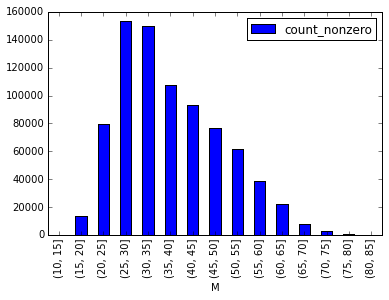

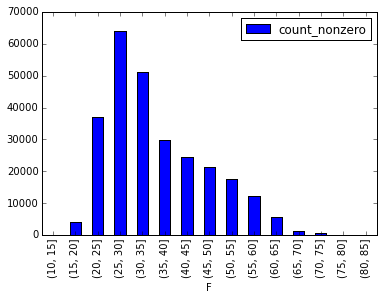

In [4]:
# Caclulating the distributions for the ages of the riders, ages between 10 and 90 are aggregated into groups of 5 years wide.
bins = np.arange(10, 90, 5)
mplot=ages.M.groupby(pd.cut(ages.M, bins)).agg([count_nonzero]).plot(kind='bar')
fplot=ages.F.groupby(pd.cut(ages.F, bins)).agg([count_nonzero]).plot(kind='bar')

          count_nonzero
M                      
(10, 15]            NaN
(15, 20]       0.002142
(20, 25]       0.036908
(25, 30]       0.085288
(30, 35]       0.089603
(35, 40]       0.066639
(40, 45]       0.042734
(45, 50]       0.026600
(50, 55]       0.015686
(55, 60]       0.013270
(60, 65]       0.006869
(65, 70]       0.001769
(70, 75]       0.000216
(75, 80]       0.000181
(80, 85]       0.000000


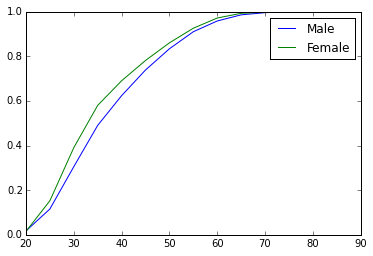

In [5]:
# Calculating cumulative distributions of ages for male and female riders
M=ages.M.groupby(pd.cut(ages.M, bins)).agg([count_nonzero]).cumsum()
F=ages.F.groupby(pd.cut(ages.F, bins)).agg([count_nonzero]).cumsum()

# Printing out the normalized differences between the probabilities for male and female riders
print np.abs(M / np.max(M)-F / np.max(F))

#plotting the cumulative distributions
mplot=pl.plot(bins[:-1] + 5, M / np.max(M), label = "Male")
fplot=pl.plot(bins[:-1] + 5, F / np.max(F), label = "Female")
lplot=pl.legend()

### 2. Performing Kolmogorov-Smirnov, Pearson's and Spearman's tests, using SciPy library + calculating Kolmogorov-Smirnov from scratch
### Kolmogorov-Smirnov

In [6]:
# Calculating the Kolmogorov-Smirnov statistic for the ages of male and female riders
ks=scipy.stats.ks_2samp(ages.M, ages.F)

#print "Kolmogorov-Smirnov statistic = ", ks.d
#print "p-value = ", ks.p-value
print "Kolmogorov-Smirnov statistc = %s, p-value = %s" %ks

Kolmogorov-Smirnov statistc = 0.499403478351, p-value = 0.0


#### Table with $\alpha$ and $c$$(\alpha$$)$ values for K-S test
| $\alpha$   | $0.10$ | $0.05$ | $0.025$ | $0.01$ | $0.005$ | $0.001$ |         
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | 
| $c$$(\alpha$$)$| $1.22$ | $1.36$ | $1.48$ | $1.63$  | $1.73$  | $1.95$  |

####  P-value for K-S statistic shows the chance that the value of the Komogorov-Smirnov D statistic would be as large or larger than #### observed. Having the significance level of 0.05, the c(a) value is 1.36, according to the table. The test returned the statistic value of 0.5 and p-value of 0, therefore we reject the null-hypothesis
#### The next block is my implementation of the K-S test. The implementation will calculate the right side of the inequality to compare the result to the values from the table
$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

In [7]:
# Counting sizes of the Male and Female riders samples
n_1=(isnan(ages.M)==0).sum()
n_2=(isnan(ages.F)==0).sum()
print "The size of the male sample is %s, the size of the female sample is %s " %(n_1, n_2)

The size of the male sample is 808552, the size of the female sample is 269400 


#### calculating the right side value, $c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

In [8]:
# Having the significance level of 0.05 returns c(a) of 1.36, according to the table.

c_a_sqrt = 1.36*sqrt(1.0*(n_1+n_2)/(n_1*n_2))
print "Right side of the inequality, c(a)*sqrt = ", c_a_sqrt

# Calculating cumulative distributions of ages for male and female riders
bins = np.arange(10, 90, 1)
M_ks=ages.M.groupby(pd.cut(ages.M, bins)).agg([count_nonzero]).cumsum()
F_ks=ages.F.groupby(pd.cut(ages.F, bins)).agg([count_nonzero]).cumsum()
# Calculating Kolmogorov-Smirnov statistic
D_ks = np.max(abs(M_ks/ np.max(M_ks)- F_ks/ np.max(F_ks)))
print "Kolmogorov-Smirnov statistic = ", D_ks.count_nonzero

Right side of the inequality, c(a)*sqrt =  0.00302542120238
Kolmogorov-Smirnov statistic =  0.0925687590148


#### Having the significance level of 0.05, the c(a) value is 1.36, according to the table. The test returned the statistic value of 0.093, while the calculated $c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$ is equal to 0.003, which is less than the 0.093. Therefore, the null-hypothesis is rejected. 
#### Calculated manually Kolmogorov-Smirnov test happened to decline from the Scipy one. It produced the same result, but the result is much less accurate.
### Pearson's test

In [9]:
# checking the sizes of the Male and Female samples 
# cleaning samples from NaN values
M= ages.M[isnan(ages.M)==0]
F= ages.F[isnan(ages.F)==0]
# randomly equalizing the sizes of samples, by selecting random samples from the bigger samples
# of the size of the size of the smaller sample
if (M.count()>F.count()):
    M = M.sample(F.count())
if (M.count()<F.count()):
    F = F.sample(M.count()) 

pearson = scipy.stats.pearsonr(M, F)
print "Two-tailed pearson p-values: %s %s" %pearson

#print "Since Pearson’s correlation coefficient is close to 0, there is no linear relationship"

Two-tailed pearson p-values: 0.00329917436851 0.0868244220726


#### having the r-value really small, <<0.0033 indicates that there is no linear correlation between the Male and Female ages
### Spearman's test

In [10]:
#please perform the Spearman's test and tell me what you find
spearman = spearmanr(M, F,axis=0)
print spearman

(0.0029914627849368892, 0.12050011741076774)


#### The Spearman test returned the correlation coefficient of 0.0029, meaning that there is a very small correlation between the distributions; and a p-value of 0.12 for a hypothesis test of two distributions whose variables are uncorrelated.

## Repeating the tests for the day vs the night riders
### 1. Loading, cleaning, and summarizing the citibike data, plotting histograms

In [11]:
# Reading the citibike data for September, 2015; 201509-citibike-tripdata.csv,
# selecting only birth year, usertype, and gender columns
# https://drive.google.com/file/d/0B8EwoI-cGyuZY0QwWlFmNjlnMms/edit
# I assume for the simplicity that sunrises in NYC in September are at 6 a.m. and sunsets are at 8 p.m.
# Therefore the day is considered to be from 6 a.m. to 8 p.m.
# Reading the data
#ages = pd.read_csv('201509-citibike-tripdata.csv')
ages = pd.read_csv('201509-citibike-tripdata.csv', parse_dates=['starttime'], header=0, usecols=["starttime", 
                                                                                                 "birth year", "usertype"])
# filtering Subscribers, removing Customers
ages = ages[ages.usertype == "Subscriber"]
print ages

                  starttime    usertype  birth year
0       2015-09-01 00:00:00  Subscriber        1989
1       2015-09-01 00:00:00  Subscriber        1987
3       2015-09-01 00:00:07  Subscriber        1992
4       2015-09-01 00:00:09  Subscriber        1976
5       2015-09-01 00:00:13  Subscriber        1955
6       2015-09-01 00:00:49  Subscriber        1964
8       2015-09-01 00:00:53  Subscriber        1975
10      2015-09-01 00:01:05  Subscriber        1994
11      2015-09-01 00:01:06  Subscriber        1984
12      2015-09-01 00:01:37  Subscriber        1993
...                     ...         ...         ...
1289687 2015-09-30 23:57:55  Subscriber        1982
1289688 2015-09-30 23:58:14  Subscriber        1990
1289689 2015-09-30 23:58:21  Subscriber        1982
1289690 2015-09-30 23:58:34  Subscriber        1982
1289691 2015-09-30 23:58:37  Subscriber        1990
1289692 2015-09-30 23:58:44  Subscriber        1980
1289693 2015-09-30 23:58:56  Subscriber        1982
1289696 2015

In [12]:
# Extracting day-time and night-time riders data, and removing extra fields
ages['D'] = 2015-ages['birth year'][(ages['starttime'].dt.hour >= 6) & (ages['starttime'].dt.hour <=20)]
ages['N'] = 2015-ages['birth year'][(ages['starttime'].dt.hour >=20) | (ages['starttime'].dt.hour <=6)]
ages.drop(['usertype', 'birth year'], axis=1, inplace=True)
print ages

                  starttime   D   N
0       2015-09-01 00:00:00 NaN  26
1       2015-09-01 00:00:00 NaN  28
3       2015-09-01 00:00:07 NaN  23
4       2015-09-01 00:00:09 NaN  39
5       2015-09-01 00:00:13 NaN  60
6       2015-09-01 00:00:49 NaN  51
8       2015-09-01 00:00:53 NaN  40
10      2015-09-01 00:01:05 NaN  21
11      2015-09-01 00:01:06 NaN  31
12      2015-09-01 00:01:37 NaN  22
...                     ...  ..  ..
1289687 2015-09-30 23:57:55 NaN  33
1289688 2015-09-30 23:58:14 NaN  25
1289689 2015-09-30 23:58:21 NaN  33
1289690 2015-09-30 23:58:34 NaN  33
1289691 2015-09-30 23:58:37 NaN  25
1289692 2015-09-30 23:58:44 NaN  35
1289693 2015-09-30 23:58:56 NaN  33
1289696 2015-09-30 23:59:44 NaN  36
1289697 2015-09-30 23:59:48 NaN  30
1289698 2015-09-30 23:59:57 NaN  38

[1079592 rows x 3 columns]


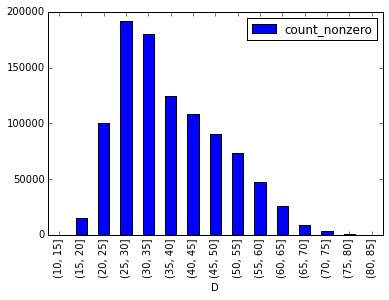

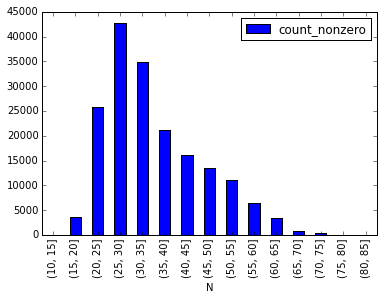

In [13]:
# Caclulating the distributions for the ages of the riders, ages between 10 and 90 are aggregated into groups of 5 years wide.
bins = np.arange(10, 90, 5)
mplot=ages.D.groupby(pd.cut(ages.D, bins)).agg([count_nonzero]).plot(kind='bar')
fplot=ages.N.groupby(pd.cut(ages.N, bins)).agg([count_nonzero]).plot(kind='bar')

          count_nonzero
D                      
(10, 15]            NaN
(15, 20]       0.004437
(20, 25]       0.044560
(25, 30]       0.084715
(30, 35]       0.092754
(35, 40]       0.081512
(40, 45]       0.059190
(45, 50]       0.040442
(50, 55]       0.025945
(55, 60]       0.013354
(60, 65]       0.005790
(65, 70]       0.001556
(70, 75]       0.000408
(75, 80]       0.000064
(80, 85]       0.000000


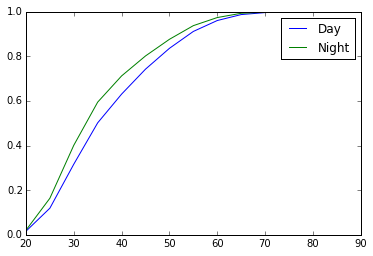

In [14]:
# Calculating cumulative distributions of ages for day and night riders
D=ages.D.groupby(pd.cut(ages.D, bins)).agg([count_nonzero]).cumsum()
N=ages.N.groupby(pd.cut(ages.N, bins)).agg([count_nonzero]).cumsum()

# Printing out the normalized differences between the probabilities for day and night riders
print np.abs(D / np.max(D)-N / np.max(N))

#plotting the cumulative distributions
mplot=pl.plot(bins[:-1] + 5, D / np.max(D), label = "Day")
fplot=pl.plot(bins[:-1] + 5, N / np.max(N), label = "Night")
lplot=pl.legend()

### 2. Performing Kolmogorov-Smirnov, Pearson's and Spearman's tests, using SciPy library + calculating Kolmogorov-Smirnov from scratch
### Kolmogorov-Smirnov

In [15]:
# Calculating the Kolmogorov-Smirnov statistic for the ages of day and night riders
ks=scipy.stats.ks_2samp(ages.D, ages.N)

#print "Kolmogorov-Smirnov statistic = ", ks.d
#print "p-value = ", ks.p-value
print "Kolmogorov-Smirnov statistc = %s, p-value = %s" %ks

Kolmogorov-Smirnov statistc = 0.733807771825, p-value = 0.0


#### Table with $\alpha$ and $c$$(\alpha$$)$ values for K-S test
| $\alpha$   | $0.10$ | $0.05$ | $0.025$ | $0.01$ | $0.005$ | $0.001$ |         
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | 
| $c$$(\alpha$$)$| $1.22$ | $1.36$ | $1.48$ | $1.63$  | $1.73$  | $1.95$  |

####  P-value for K-S statistic shows the chance that the value of the Komogorov-Smirnov D statistic would be as large or larger than #### observed. Having the significance level of 0.05, the c(a) value is 1.36, according to the table. The test returned the statistic value of 0.73 and p-value of 0, therefore we reject the null-hypothesis
#### The next block is my implementation of the K-S test. The implementation will calculate the right side of the inequality to compare the result to the values from the table
$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

In [16]:
# Counting sizes of the day and night riders samples
n_1=(isnan(ages.D)==0).sum()
n_2=(isnan(ages.N)==0).sum()
print "The size of the day sample is %s, the size of the night sample is %s " %(n_1, n_2)

The size of the day sample is 972710, the size of the night sample is 180497 


#### calculating the right side value, $c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

In [17]:
# Having the significance level of 0.05 returns c(a) of 1.36, according to the table.

c_a_sqrt = 1.36*sqrt(1.0*(n_1+n_2)/(n_1*n_2))
print "Right side of the inequality, c(a)*sqrt = ", c_a_sqrt

# Calculating cumulative distributions of ages for day and night riders
bins = np.arange(10, 90, 1)
D_ks=ages.D.groupby(pd.cut(ages.D, bins)).agg([count_nonzero]).cumsum()
N_ks=ages.N.groupby(pd.cut(ages.N, bins)).agg([count_nonzero]).cumsum()
# Calculating Kolmogorov-Smirnov statistic
DD_ks = np.max(abs(D_ks/ np.max(D_ks)- N_ks/ np.max(N_ks)))
print "Kolmogorov-Smirnov statistic = ", DD_ks.count_nonzero

Right side of the inequality, c(a)*sqrt =  0.0034855061951
Kolmogorov-Smirnov statistic =  0.0936442986523


#### Having the significance level of 0.05, the c(a) value is 1.36, according to the table. The test returned the statistic value of 0.094, while the calculated $c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$ is equal to 0.0035, which is less than the 0.093. Therefore, the null-hypothesis is rejected. 
#### Calculated manually Kolmogorov-Smirnov test happened to decline from the Scipy one. It produced the same result, but the result is much less accurate.
### Pearson's test

In [18]:
# checking the sizes of the day and night samples 
# cleaning samples from NaN values
D= ages.D[isnan(ages.D)==0]
N= ages.N[isnan(ages.N)==0]
# randomly equalizing the sizes of samples, by selecting random samples from the bigger samples
# of the size of the size of the smaller sample
if (D.count()>N.count()):
    D = D.sample(N.count())
if (D.count()<N.count()):
    N = N.sample(D.count()) 

pearson = scipy.stats.pearsonr(D, N)
print "Two-tailed pearson p-values: %s %s" %pearson

#print "Since Pearson’s correlation coefficient is close to 0, there is no linear relationship"

Two-tailed pearson p-values: 0.00508537480231 0.0307326408951


#### having the r-value really small, <<0.0051 indicates that there is no linear correlation between the Male and Female ages
### Spearman's test

In [20]:
#please perform the Spearman's test and tell me what you find
spearman = spearmanr(D, N,axis=0)
print spearman

(0.0070772950347473915, 0.0026401229596372958)


#### The Spearman test returned the correlation coefficient of 0.0071, meaning that there is a very small correlation between the distributions; and a p-value of 0.0026 for a hypothesis test of two distributions whose variables are uncorrelated.